In [1]:
############********** Project1 Task2 Training File **********############


import pyodbc
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import sys
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.metrics import plot_confusion_matrix

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier


# pearson's correlation feature selection for numeric input and numeric output
from sklearn.datasets import make_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.datasets import make_classification
from sklearn_pandas import CategoricalImputer
#from feature_engine.imputation import CategoricalImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from matplotlib import pyplot
import datetime as dt

from datetime import date
import holidays

pd.set_option("display.max_columns", None)


In [2]:
###--- Connecting to the server to access the database ---###

conn = pyodbc.connect('Driver={SQL Server};'
'Server=HCV171DTMBPDA01\DTMBSQL16PRD.NGDS.state.mi.us,1910;'
'Database=DTMB_CentralProcurement;'
'Trusted_Connection=yes;')

cursor = conn.cursor()

In [3]:
###--- Retrieving tables from the database using queries ---###

query_1 = "SELECT * FROM tblProjects WHERE ProjectType = 'RFP' Or ProjectType\
= 'C-RFP' Or ProjectType = 'CN' Or ProjectType = 'DS' Or ProjectType = 'CO-OP'Or ProjectType = 'ITN'Or ProjectType = 'CPC' Or ProjectType = 'RFS'"
query_2 = "SELECT * FROM tblContractCategories"


df_projects = pd.read_sql_query(query_1, conn)
df_projects = df_projects[df_projects['CategoryID'].notna()]
df_projects = df_projects.astype({'CategoryID': 'int64'})

df_level = pd.read_sql_query(query_2, conn)
df_level = df_level[['LevelCalc', 'CategoryID']]

df = df_projects.join(df_level.set_index('CategoryID'), on='CategoryID')
df = df[(df["ProjectStage"] == 'Complete')]
df.shape

(4188, 35)

# Data Preparation and Cleansing 

In [4]:
###--- Data pre-processing and cleaning for training model---###

def prepare_df2(df):
    
    #Calculating the duration
    df = df.reset_index()
    df = df.dropna(subset=['PlanFinishDate'])
    mi_holidays = holidays.UnitedStates(state='MI')
    start = df['PlanStartDate'].astype(str)
    end = df['ActualFinishDate'].astype(str)
    bus = []
    holi = []
    dur = []
    start_list = start.tolist()
    end_list = end.tolist()
    for i in range(len(start_list)):
        holi.append(len(mi_holidays[start_list[i]: end_list[i]]))
        bus.append(np.busday_count(start_list[i], end_list[i]))

    zip_object = zip(bus, holi)
    for list1_i, list2_i in zip_object:
        dur.append(list1_i-list2_i)
    df['dur'] = dur
    variables_to_remove = ['index','SharePointID', 'ID', 'ProjectName', 'CreateDate', 'PlanStartDate',
             'PlanFinishDate', 'StatusDate', 'ProjectDescription', 'Status', 'StatusDate', 'ProjectDescription',
             'Status', 'RefrenceNumber', 'ProjectStage', 'CancelationReason', 'ActualFinishDate', 'Unit',
             'SolicitationStatus', 'LastUpdatedBy', 'LastUpdateDate', 'LastUpdatedField', 'SolicitationNum',
             'SensitivityIndicator', 'SourcingCategory', 'DollarAmount'] # Business requested removal of the following features

    df = df.drop(variables_to_remove, axis = 1)
    df = df.rename(columns={"dur": "Duration"})
    df = df[df["Duration"]>0]
    # handling NaN values
    imputer = CategoricalImputer()
    data = np.array(df['Planned'], dtype=object)
    data2 = np.array(df['CreatedBy'], dtype=object)
    data3 = np.array(df['BuyerName'], dtype=object)

    df['Planned'] = imputer.fit_transform(data)
    df['CreatedBy'] = imputer.fit_transform(data2)
    df['BuyerName'] = imputer.fit_transform(data3)
    df = df.dropna()
    df = df.reset_index()
    df = df.drop('index', axis = 1)
    return df

def met_sla(df):
    
    if df['Duration'] <= df['SLA']:
        val = 1
    elif df['Duration'] > df['SLA']:
        val = 0
    return val

model2_df = prepare_df2(df)
model2_df['Met_SLA'] = model2_df.apply(met_sla, axis=1)
model2_df.head()

,ProjectColor,ProjectType,CreatedBy,WorkPerformedFor,BuyerName,Hours,Division,SLA,Planned,CategoryID,FedReview,ITComponent,LevelCalc,Duration,Met_SLA
0,Green,CN,keilenn,071,JY1,0.0,PROF,63,Yes,50,False,False,3,5,1
1,Green,RFP,Gibrilm,000,YMD,120.0,COMM,138,Yes,185,False,False,2,54,1
2,Green,RFP,Gibrilm,000,YMD,120.0,COMM,138,No,184,False,False,3,58,1
3,Green,RFP,Gibrilm,591,YMD,120.0,COMM,138,No,301,False,False,2,101,1
4,Green,RFP,Gibrilm,431,SR4,120.0,COMM,138,No,143,False,False,4,172,0


# Creating Labels for Different durations

In [5]:
#putting duration ranges into categories

duration = []
for item in model2_df['Duration'].to_list():
    if abs(int(item)) >=0 and abs(int(item)) < 50:
        duration.append(1)
    elif abs(int(item)) >=50 and abs(int(item)) < 100:
        duration.append(2)
    elif abs(int(item)) >=100 and abs(int(item)) < 150:
        duration.append(3)
    elif abs(int(item)) >=150 and abs(int(item)) < 200:
        duration.append(4)
    elif abs(int(item)) >=200 and abs(int(item)) < 250:
        duration.append(5)
    elif abs(int(item)) >=250 and abs(int(item)) < 300:
        duration.append(6)
    elif abs(int(item)) >=300 and abs(int(item)) < 350:
        duration.append(7)
    elif abs(int(item)) >=350 and abs(int(item)) < 400:
        duration.append(8)
    elif abs(int(item)) >=400:
        duration.append(9)

#creating duration category column
model2_df['DurationCat'] = duration
model2_df = model2_df.drop(['Duration'], axis = 1)

print(model2_df.shape)
model2_df.head()


(3373, 15)


,ProjectColor,ProjectType,CreatedBy,WorkPerformedFor,BuyerName,Hours,Division,SLA,Planned,CategoryID,FedReview,ITComponent,LevelCalc,Met_SLA,DurationCat
0,Green,CN,keilenn,071,JY1,0.0,PROF,63,Yes,50,False,False,3,1,1
1,Green,RFP,Gibrilm,000,YMD,120.0,COMM,138,Yes,185,False,False,2,1,2
2,Green,RFP,Gibrilm,000,YMD,120.0,COMM,138,No,184,False,False,3,1,2
3,Green,RFP,Gibrilm,591,YMD,120.0,COMM,138,No,301,False,False,2,1,3
4,Green,RFP,Gibrilm,431,SR4,120.0,COMM,138,No,143,False,False,4,0,4


In [6]:
from sklearn.impute import SimpleImputer
#X = model2_df.iloc[:,3 ].values
#imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
#imputer = imputer.fit(X[:, 1:3])
#X[:, 3] = imputer.transform(X[:, 3])

#model2_df['DollarAmount'] = model2_df['DollarAmount'].fillna((model2_df['DollarAmount'].mean()))

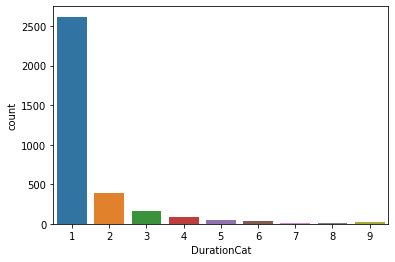

In [7]:
sns.countplot(model2_df['DurationCat'],label="Count")

In [8]:
model2_df.columns

Index(['ProjectColor', 'ProjectType', 'CreatedBy', 'WorkPerformedFor',
       'BuyerName', 'Hours', 'Division', 'SLA', 'Planned', 'CategoryID',
       'FedReview', 'ITComponent', 'LevelCalc', 'Met_SLA', 'DurationCat'],
      dtype='object')

# Feature Selection 

In [9]:
X = model2_df[['ProjectColor', 'ProjectType', 'CreatedBy',  'WorkPerformedFor', 'BuyerName', 'Hours', 'Division', 'SLA', 'Planned',
         'CategoryID', 'FedReview', 'ITComponent', 'LevelCalc', 'Met_SLA']]
y = model2_df['DurationCat']

In [10]:
from matplotlib import pyplot as plt

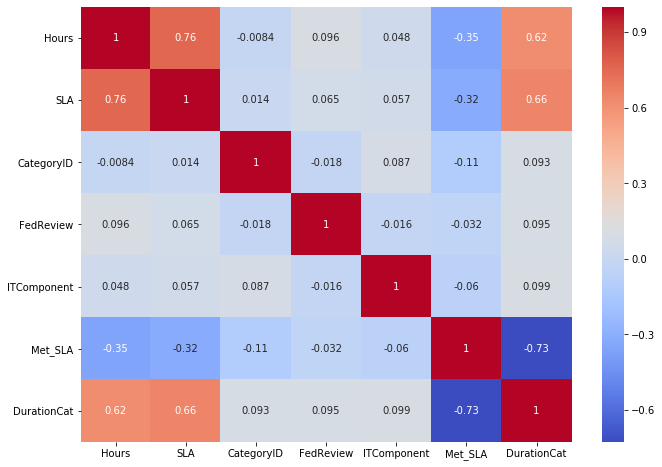

In [27]:
corr = model2_df.corr()
plt.figure(figsize=(11,8))
sns.heatmap(corr, cmap="coolwarm",annot=True)
plt.show()

In [12]:
###--- Functions that prepares data for model--> turns data entries to a form the model can read ---###

def prepare_inputs(X_train, X_test):
    oe = OrdinalEncoder(handle_unknown = "use_encoded_value", unknown_value= 569)
    oe.fit(X_train)
    X_train_enc = oe.transform(X_train)
    X_test_enc = oe.transform(X_test)
    return X_train_enc, X_test_enc

# prepare target
def prepare_targets(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    return y_train_enc, y_test_enc

# feature selection
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=chi2, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

X = model2_df.iloc[:, :-1]
y = model2_df.iloc[:,-1]
    # format all fields as string
X = X.astype(str)
np.set_printoptions(threshold=sys.maxsize)
num = 0
feature_name = []
for i in X:
    print("Feature number: "+str(num)+" "+str(i))
    num+=1
    feature_name.append(i)

Feature number: 0 ProjectColor
Feature number: 1 ProjectType
Feature number: 2 CreatedBy
Feature number: 3 WorkPerformedFor
Feature number: 4 BuyerName
Feature number: 5 Hours
Feature number: 6 Division
Feature number: 7 SLA
Feature number: 8 Planned
Feature number: 9 CategoryID
Feature number: 10 FedReview
Feature number: 11 ITComponent
Feature number: 12 LevelCalc
Feature number: 13 Met_SLA


In [13]:
###--- Running algorithm that selects the best features ---###


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# prepare input data
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)
# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train_enc, y_train_enc, X_test_enc)
# what are scores for the features
feature_score = []
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))
    feature_score.append(fs.scores_[i])
unique_elements, counts_elements = np.unique(y_train_enc, return_counts=True)


Feature 0: 106.037709
Feature 1: 974.281142
Feature 2: 173.378386
Feature 3: 77.153730
Feature 4: 138.020170
Feature 5: 1825.519316
Feature 6: 7.900681
Feature 7: 151.785003
Feature 8: 69.979729
Feature 9: 158.479049
Feature 10: 25.776418
Feature 11: 48.973949
Feature 12: 5.000824
Feature 13: 259.471282


In [14]:
from sklearn.feature_selection import mutual_info_classif as MIC
mi_score = MIC(X_train_enc,y_train_enc)
for i in mi_score:
    print(round(i,2))

0.0
0.14
0.04
0.0
0.04
0.13
0.04
0.16
0.01
0.04
0.0
0.01
0.0
0.34


In [15]:
df_featur_selection = pd.DataFrame()
df_featur_selection['Feature_Name'] = feature_name
df_featur_selection['Feature_Score'] = feature_score
df_featur_selection['mi_scores'] = mi_score
df_featur_selection = df_featur_selection.sort_values(by ='mi_scores',ascending=False )

df_featur_selection

,Feature_Name,Feature_Score,mi_scores
13,Met_SLA,259.471282,0.343786
7,SLA,151.785003,0.159962
1,ProjectType,974.281142,0.144888
5,Hours,1825.519316,0.127843
2,CreatedBy,173.378386,0.040996
9,CategoryID,158.479049,0.038784
4,BuyerName,138.020170,0.038238
6,Division,7.900681,0.037179
8,Planned,69.979729,0.009875
11,ITComponent,48.973949,0.009569


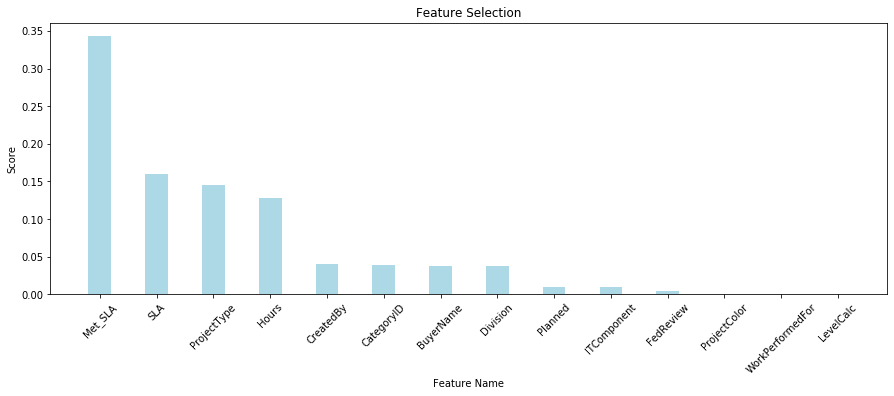

In [16]:
fig = plt.figure(figsize = (15, 5))
 
# creating the bar plot
bar = plt.bar(df_featur_selection['Feature_Name'], df_featur_selection['mi_scores'], color ='lightblue',
        width = 0.4)
plt.xticks(rotation = 45)
plt.xlabel("Feature Name")
plt.ylabel("Score")
plt.title("Feature Selection")
plt.show()

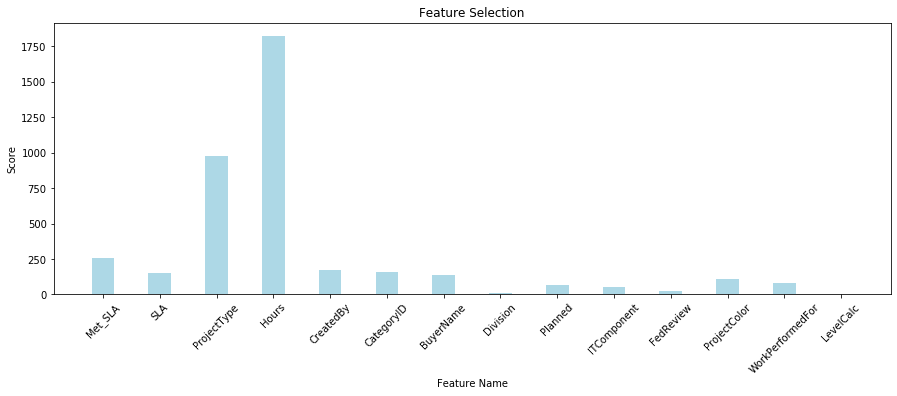

In [17]:

fig = plt.figure(figsize = (15, 5))
 
# creating the bar plot
bar = plt.bar(df_featur_selection['Feature_Name'], df_featur_selection['Feature_Score'], color ='lightblue',
        width = 0.4)
plt.xticks(rotation = 45)
plt.xlabel("Feature Name")
plt.ylabel("Score")
plt.title("Feature Selection")
plt.show()

# Bias handling and Model Selection 

In [18]:
X_train_enc = np.delete(X_train_enc, np.s_[10, 11], 1)
X_test_enc = np.delete(X_test_enc, np.s_[10, 11], 1)

In [19]:
oversample = SMOTE(random_state=42, sampling_strategy={0:2500, 1:2500, 2:2000, 3:2000, 4:2000, 5:2000, 6:2000, 8:2000})
X_s, y_s = oversample.fit_resample(X_train_enc, y_train_enc)

C:\Users\gibrilm\AppData\Local\Continuum\anaconda3\lib\site-packages\imblearn\utils\_validation.py:300: UserWarning: After over-sampling, the number of samples (2500) in class 0 will be larger than the number of samples in the majority class (class #0 -> 1766)
  f"After over-sampling, the number of samples ({n_samples})"
C:\Users\gibrilm\AppData\Local\Continuum\anaconda3\lib\site-packages\imblearn\utils\_validation.py:300: UserWarning: After over-sampling, the number of samples (2500) in class 1 will be larger than the number of samples in the majority class (class #0 -> 1766)
  f"After over-sampling, the number of samples ({n_samples})"
C:\Users\gibrilm\AppData\Local\Continuum\anaconda3\lib\site-packages\imblearn\utils\_validation.py:300: UserWarning: After over-sampling, the number of samples (2000) in class 2 will be larger than the number of samples in the majority class (class #0 -> 1766)
  f"After over-sampling, the number of samples ({n_samples})"
C:\Users\gibrilm\AppData\Local\

In [20]:
def ave_score(model):
    scores=[]
    for i in range(10):
        model.fit(X_s, y_s)
        score = model.score(X_test_enc, y_test_enc)
        scores.append(score)
    return sum(scores)/len(scores)
    

In [21]:
ave_score(RandomForestClassifier(n_estimators=1000))

0.8671454219030521

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
result_df = pd.DataFrame()

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=1000, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]


for name, clf in zip(names, classifiers):
            clf.fit(X_s, y_s)
            score = clf.score(X_test_enc, y_test_enc)
            #score= ave_score(clf)
            name_lst.append(name)
            result_model.append(score)
            print(name, score)
        
       
result_df['model Name'] = name_lst
result_df['score'] = result_model

result_df

Nearest Neighbors 0.618491921005386
Linear SVM 0.8527827648114902
RBF SVM 0.44703770197486536
Decision Tree 0.8707360861759426
Random Forest 0.8563734290843806
Neural Net 0.8393177737881508
AdaBoost 0.059245960502693
Naive Bayes 0.7935368043087971
QDA 0.7639138240574507


C:\Users\gibrilm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\gibrilm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:903: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
C:\Users\gibrilm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:903: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
C:\Users\gibrilm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:906: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])


,model Name,score
0,Nearest Neighbors,0.618492
1,Linear SVM,0.852783
2,RBF SVM,0.447038
3,Decision Tree,0.870736
4,Random Forest,0.860862
5,Neural Net,0.834829
6,AdaBoost,0.059246
7,Naive Bayes,0.793537
8,QDA,0.763914
9,Nearest Neighbors,0.618492


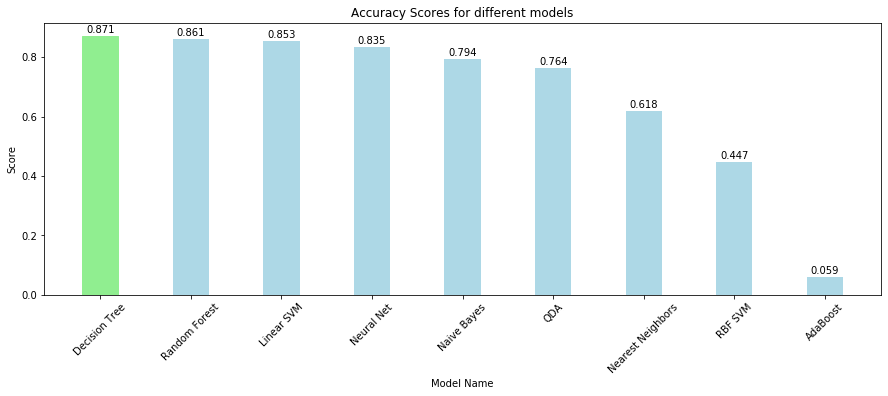

In [23]:
result_df = result_df.sort_values(by= 'score',ascending=False )

fig = plt.figure(figsize = (15, 5))
 
# creating the bar plot
bar = plt.bar(result_df['model Name'], result_df['score'], color ='lightblue',
        width = 0.4)
plt.xticks(rotation = 45)
plt.xlabel("Model Name")
plt.ylabel("Score")
plt.title("Accuracy Scores for different models")

for x,y in zip(result_df['model Name'], result_df['score']):

    label = "{:.3f}".format(y)
    plt.annotate(label,
                 (x,y), 
                 textcoords="offset points", 
                 xytext=(0,3), 
                 ha='center') 
bar[0].set_color('lightgreen')
#plt.text(4.5,.85,'Random Forest Classifier'+str(max(result_df['score'])))
plt.show()

In [24]:
def evaluate_model(X, y, model):
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    # evaluate model
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

#run algorithm multiple times to get desired accuracy
desired_accu = 0
while desired_accu < 0.87:

    
    #oversample training data to avoid skewness
    oversample = SMOTE(random_state=42, sampling_strategy={0:2500, 1:2500, 2:2000, 3:2000, 4:2000, 5:2000, 6:2000, 8:2000})
    X_s, y_s = oversample.fit_resample(X_train_enc, y_train_enc)
    #X_test = X_test.to_numpy()

    model = RandomForestClassifier(n_estimators=1000).fit(X_s, y_s)

    model = model.fit(X_s, y_s)
    # evaluate the model
    scores = evaluate_model(X_test_enc, y_test_enc, model)
    desired_accu = np.mean(scores)
    print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))



C:\Users\gibrilm\AppData\Local\Continuum\anaconda3\lib\site-packages\imblearn\utils\_validation.py:300: UserWarning: After over-sampling, the number of samples (2500) in class 0 will be larger than the number of samples in the majority class (class #0 -> 1766)
  f"After over-sampling, the number of samples ({n_samples})"
C:\Users\gibrilm\AppData\Local\Continuum\anaconda3\lib\site-packages\imblearn\utils\_validation.py:300: UserWarning: After over-sampling, the number of samples (2500) in class 1 will be larger than the number of samples in the majority class (class #0 -> 1766)
  f"After over-sampling, the number of samples ({n_samples})"
C:\Users\gibrilm\AppData\Local\Continuum\anaconda3\lib\site-packages\imblearn\utils\_validation.py:300: UserWarning: After over-sampling, the number of samples (2000) in class 2 will be larger than the number of samples in the majority class (class #0 -> 1766)
  f"After over-sampling, the number of samples ({n_samples})"
C:\Users\gibrilm\AppData\Local\

Mean Accuracy: 0.871 (0.016)
